In [1]:
# --- INSTALLS ---
# Kaggle usually has these, but good to ensure versions
!pip install -q scikit-learn==1.5.2
!pip install -q nltk==3.9.1 tqdm==4.66.5
!pip install -q lightgbm==4.5.0

# --- IMPORTS ---
import os, re, string, pickle, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import lightgbm as lgb # <--- CHANGED TO LIGHTGBM

from tqdm import tqdm
from pprint import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc,
                             average_precision_score, precision_recall_curve)
from sklearn.utils.class_weight import compute_class_weight

from scipy import sparse

# --- TEXT PREP (NLTK) ---\
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

# --- TF-IDF ---
from sklearn.feature_extraction.text import TfidfVectorizer

# --- PLOTTING ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.dpi"] = 130

RNG = 42
N_CLASSES = 3

# --- PATHS (KAGGLE SPECIFIC) ---
# IMPORTANT: Update 'your-dataset-name' to the actual folder name in Kaggle inputs
# It usually looks like: /kaggle/input/movie-reviews-dataset/Composite2_194k data.csv
CSV_PATH = "/kaggle/input/ml-194k-c2-2/Composite2_194k data.csv" 
BASE_SAVE_DIR = "/kaggle/working/LightGBM_Multiclass"
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

# --- LOAD ---
# Check if file exists to prevent crash
if not os.path.exists(CSV_PATH):
    print(f"WARNING: File not found at {CSV_PATH}. Please check your Kaggle Input path.")
else:
    df = pd.read_csv(CSV_PATH)

    # --- BASIC CLEANING (MULTICLASS VERSION) ---
    need = ['title','reviewText','target_label','tomatoMeter','genre','audienceScore',
            'runtimeMinutes','language_encoded','director_encoded']
    missing = [c for c in need if c not in df.columns]
    
    if not missing:
        # Drop rows with missing target or review text
        df = df.dropna(subset=['reviewText','target_label']).copy()
        df['label'] = df['target_label'].astype(int)

        # Verify we have 3 classes: 0 (Negative), 1 (Neutral), 2 (Positive)
        assert df['label'].isin([0, 1, 2]).all(), "Labels must be 0, 1, or 2"

        # Keep only needed columns
        df['title'] = df['title'].fillna("")
        df['genre'] = df['genre'].fillna("Unknown")

        class_names = ['Negative', 'Neutral', 'Positive']
        print("Rows:", len(df))
        print("Class distribution:")
        print(df['label'].value_counts().sort_index())
        print("\nClass proportions:")
        print(df['label'].value_counts(normalize=True).sort_index().round(4))

# --- TEXT PREPROCESSING ---
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = s.lower()
    # contractions (quick pass)
    s = re.sub(r"'", "'", s)
    s = re.sub(r"n't\b", " not", s)
    s = re.sub(r"'re\b", " are", s)
    s = re.sub(r"'s\b", " is", s)
    s = re.sub(r"'d\b", " would", s)
    s = re.sub(r"'ll\b", " will", s)
    s = re.sub(r"'ve\b", " have", s)
    s = re.sub(r"'m\b", " am", s)
    # remove urls/emails/handles
    s = re.sub(r"http\S+|www\.\S+|[\w\.-]+@[\w\.-]+", " ", s)
    # keep letters only
    s = re.sub(r"[^a-z\s]", " ", s)
    # tokenize → remove stopwords → lemmatize → (light) stem
    tokens = [w for w in word_tokenize(s) if w not in STOPWORDS and len(w) > 2]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    stems  = [stemmer.stem(w) for w in lemmas]
    return " ".join(stems)

def fit_tfidf(train_texts, max_features=50000, ngram_range=(1,2), min_df=3):
    vec = TfidfVectorizer(
        preprocessor=None,
        tokenizer=None,
        analyzer='word',
        ngram_range=ngram_range,
        min_df=min_df,
        max_features=max_features,
        lowercase=False,
        dtype=np.float32
    )
    X = vec.fit_transform(train_texts)
    return vec, X

def transform_tfidf(vec, texts):
    return vec.transform(texts)

print("\n✅ Part 1 Complete: Data loaded and preprocessing functions defined.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 75.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
preprocessing 0.1.13 requires nlt

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


Rows: 194784
Class distribution:
label
0    55029
1    66081
2    73674
Name: count, dtype: int64

Class proportions:
label
0    0.2825
1    0.3393
2    0.3782
Name: proportion, dtype: float64

✅ Part 1 Complete: Data loaded and preprocessing functions defined.


In [2]:
# --- MULTICLASS FEATURE ENGINEERING ---

NUM_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']

# =======================================================
# MULTICLASS DIRECTOR BLOCKS (Target Encoding)
# =======================================================
def director_blocks_multiclass(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits: int = 5):
    """
    Multiclass Target Encoding: Calculates mean for each class (0, 1, 2)
    Returns 1 freq col + 3 target mean cols (4 total features per director).
    """
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # 1. Frequency features (log1p)
    freq = s_train.value_counts()
    tr_freq = np.log1p(s_train.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)
    te_freq = np.log1p(s_test.map(freq).fillna(0).astype(float).values)[:, None].astype(np.float32)

    # 2. Multiclass Target mean encoding (leak-safe OOF)
    y_ohe = OneHotEncoder(categories=[range(N_CLASSES)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
    global_mean = y_ohe.mean(axis=0)

    tr_te = np.zeros((len(s_train), N_CLASSES), dtype=np.float32)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_fold = s_train.iloc[tr_i]
        fold_means = pd.DataFrame(y_ohe[tr_i], index=tr_fold.index).groupby(tr_fold).mean()

        val_fold = s_train.iloc[val_i].to_frame(name='did')
        merged = val_fold.merge(fold_means, left_on='did', right_index=True, how='left')
        vals = merged.drop('did', axis=1).values

        mask = np.isnan(vals.sum(axis=1))
        vals[mask] = global_mean
        tr_te[val_i] = vals.astype(np.float32)

    # Test set mapping (using full train)
    full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
    test_df_map = s_test.to_frame(name='did')
    merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
    te_te = merged_test.drop('did', axis=1).values

    mask_test = np.isnan(te_te.sum(axis=1))
    te_te[mask_test] = global_mean

    return tr_freq, te_freq, tr_te, te_te

# =======================================================
# GENRE & LANGUAGE ENCODINGS
# =======================================================
def fit_categoricals(train_genre, train_lang):
    mlb = MultiLabelBinarizer()
    G = mlb.fit_transform(train_genre)

    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=np.float32)
    L = ohe.fit_transform(train_lang.to_frame(name="lang"))
    return mlb, ohe, G, L

def transform_categoricals(mlb, ohe, genre_series, lang_series):
    G = mlb.transform(genre_series)
    L = ohe.transform(lang_series.to_frame(name="lang"))
    return G, L

# =======================================================
# NUMERICS: scale on TRAIN only
# =======================================================
def fit_scale_numeric(train_df, cols):
    scaler = StandardScaler()
    X = scaler.fit_transform(train_df[cols].fillna(train_df[cols].median()))
    return scaler, X

def transform_scale_numeric(scaler, df, cols):
    return scaler.transform(df[cols].fillna(df[cols].median()))

# =======================================================
# TRAIN/TEST SPLIT (Stratified by 3 classes)
# =======================================================
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=RNG, stratify=df['label']
)
y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"\nTrain size: {len(train_df)} | Test size: {len(test_df)}")
print("Train class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nTest class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

# =======================================================
# COMPUTE CLASS WEIGHTS (for imbalanced 3-class data)
# =======================================================
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
print(f"\nClass weights: {class_weight_dict}")

print("\n✅ Part 2 Complete: Feature engineering functions and train/test split ready.")


Train size: 155827 | Test size: 38957
Train class distribution:
0    44023
1    52865
2    58939
Name: count, dtype: int64

Test class distribution:
0    11006
1    13216
2    14735
Name: count, dtype: int64

Class weights: {0: 1.1798908146499179, 1: 0.9825467385478736, 2: 0.8812896949953907}

✅ Part 2 Complete: Feature engineering functions and train/test split ready.


In [3]:
# =======================================================
# MULTICLASS EVALUATION & PLOTTING (4-DECIMAL PRECISION)
# =======================================================

def evaluate_and_plot(model_name, setup_name, y_true, y_prob, y_pred, save_dir, class_names=['Negative', 'Neutral', 'Positive']):
    """
    Multiclass evaluation with 4-decimal precision.
    """
    os.makedirs(save_dir, exist_ok=True)
    n_classes = len(class_names)

    # Calculate metrics with weighted average (for imbalanced data)
    acc  = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n[{setup_name} | {model_name}]")
    print(f"Accuracy={acc:.4f}  F1_weighted={f1:.4f}  Precision_weighted={pr:.4f}  Recall_weighted={rc:.4f}")

    # ⭐ 4-DECIMAL CLASSIFICATION REPORT
    print("\n--- Classification Report (4 Decimal Places) ---")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, digits=4)
    print(report)

    # ⭐ CONFUSION MATRIX (Counts + Normalized with 4 decimals)
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 5))

    # Counts (Integers)
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Counts)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ⭐ 4-DECIMAL NORMALIZED CONFUSION MATRIX
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{setup_name} | {model_name}\nConfusion Matrix (Normalized, 4-Decimals)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_{setup_name}_confusion.png'), dpi=130, bbox_inches='tight')
    plt.show()

    # Per-class metrics
    pr_per_class, rc_per_class, f1_per_class, support = precision_recall_fscore_support(
        y_true, y_pred, labels=range(n_classes), zero_division=0
    )

    print("\n--- Per-Class Metrics (4 Decimals) ---")
    for i, cname in enumerate(class_names):
        print(f"{cname:10s}: Precision={pr_per_class[i]:.4f}  Recall={rc_per_class[i]:.4f}  F1={f1_per_class[i]:.4f}  Support={support[i]}")

    return {
        "accuracy": acc,
        "f1_weighted": f1,
        "precision_weighted": pr,
        "recall_weighted": rc,
        "per_class_precision": pr_per_class,
        "per_class_recall": rc_per_class,
        "per_class_f1": f1_per_class
    }

print("\n✅ Part 3 Complete: Multiclass evaluation helpers ready (4-decimal precision).")


✅ Part 3 Complete: Multiclass evaluation helpers ready (4-decimal precision).


In [4]:
# =======================================================
# BUILD ALL FEATURE MATRICES (8 Features: Review + Title + Num + Genre + Lang + Director)
# =======================================================

print("--- Building ALL Features Matrix ---")

# ---- TEXT FEATURES ----
# 1. Review Text
train_review = train_df['reviewText'].map(clean_text)
test_review  = test_df['reviewText'].map(clean_text)
tfidf_review, Xtr_review = fit_tfidf(train_review, max_features=60000, ngram_range=(1,2), min_df=3)
Xte_review = transform_tfidf(tfidf_review, test_review)

# 2. Title Text
train_title = train_df['title'].map(clean_text)
test_title  = test_df['title'].map(clean_text)
tfidf_title, Xtr_title = fit_tfidf(train_title, max_features=30000, ngram_range=(1,2), min_df=3)
Xte_title = transform_tfidf(tfidf_title, test_title)

# ---- NUMERIC FEATURES ----
scaler_all, Xtr_num_np = fit_scale_numeric(train_df, NUM_COLS)
Xte_num_np = transform_scale_numeric(scaler_all, test_df, NUM_COLS)
Xtr_num = sparse.csr_matrix(Xtr_num_np.astype(np.float32))
Xte_num = sparse.csr_matrix(Xte_num_np.astype(np.float32))

# ---- CATEGORICAL FEATURES ----
# Genre (multi-label)
train_genre = train_df['genre'].fillna("Unknown").str.split(', ')
test_genre  = test_df['genre'].fillna("Unknown").str.split(', ')

# Language (single label)
train_lang  = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
test_lang   = test_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

mlb_all, ohe_all, Xtr_genre, Xtr_lang = fit_categoricals(train_genre, train_lang)
Xte_genre, Xte_lang = transform_categoricals(mlb_all, ohe_all, test_genre, test_lang)

Xtr_genre = sparse.csr_matrix(Xtr_genre.astype(np.float32))
Xte_genre = sparse.csr_matrix(Xte_genre.astype(np.float32))

# ---- DIRECTOR FEATURES (Multiclass Target Encoding) ----
tr_f, te_f, tr_te, te_te = director_blocks_multiclass(
    train_df['director_encoded'], y_train, test_df['director_encoded']
)
Xtr_dir = sparse.csr_matrix(np.concatenate([tr_f, tr_te], axis=1).astype(np.float32))
Xte_dir = sparse.csr_matrix(np.concatenate([te_f, te_te], axis=1).astype(np.float32))

# ---- STACK ALL FEATURES ----
X_train_ALL = sparse.hstack([Xtr_review, Xtr_title, Xtr_num, Xtr_genre, Xtr_lang, Xtr_dir], format='csr')
X_test_ALL  = sparse.hstack([Xte_review, Xte_title, Xte_num, Xte_genre, Xte_lang, Xte_dir], format='csr')

print("\n--- Feature Matrix Stacking Complete ---")
print(f"X_train_ALL shape: {X_train_ALL.shape}")
print(f"X_test_ALL shape:  {X_test_ALL.shape}")
print(f"Features include: Review TF-IDF, Title TF-IDF, Numerics, Genre, Language, Director (Total: {X_train_ALL.shape[1]} features)")

print("\n✅ Part 4 Complete: ALL features matrix ready.")

--- Building ALL Features Matrix ---

--- Feature Matrix Stacking Complete ---
X_train_ALL shape: (155827, 83942)
X_test_ALL shape:  (38957, 83942)
Features include: Review TF-IDF, Title TF-IDF, Numerics, Genre, Language, Director (Total: 83942 features)

✅ Part 4 Complete: ALL features matrix ready.



LIGHTGBM — TOP 4 FEATURES (Review Text, Title, Genre, TomatoMeter)
X_train_TOP4 shape: (155827, 83922)
X_test_TOP4 shape: (38957, 83922)
Creating LightGBM Datasets...

Running 5-Fold Cross-Validation...
  Fold 1: acc=0.6341 | f1_weighted=0.6305
  Fold 2: acc=0.6305 | f1_weighted=0.6271
  Fold 3: acc=0.6325 | f1_weighted=0.6295
  Fold 4: acc=0.6305 | f1_weighted=0.6274
  Fold 5: acc=0.6351 | f1_weighted=0.6321
  LightGBM (TOP4 Features) CV mean±std | acc=0.6325±0.0019 f1_w=0.6293±0.0019

Training on full training set...
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.806299	test's multi_logloss: 0.834873
[200]	train's multi_logloss: 0.770486	test's multi_logloss: 0.81481
[300]	train's multi_logloss: 0.745733	test's multi_logloss: 0.80316
[400]	train's multi_logloss: 0.726796	test's multi_logloss: 0.794598
[500]	train's multi_logloss: 0.710017	test's multi_logloss: 0.788322
[600]	train's multi_logloss: 0.696135	test's multi_logloss: 0.783853
[

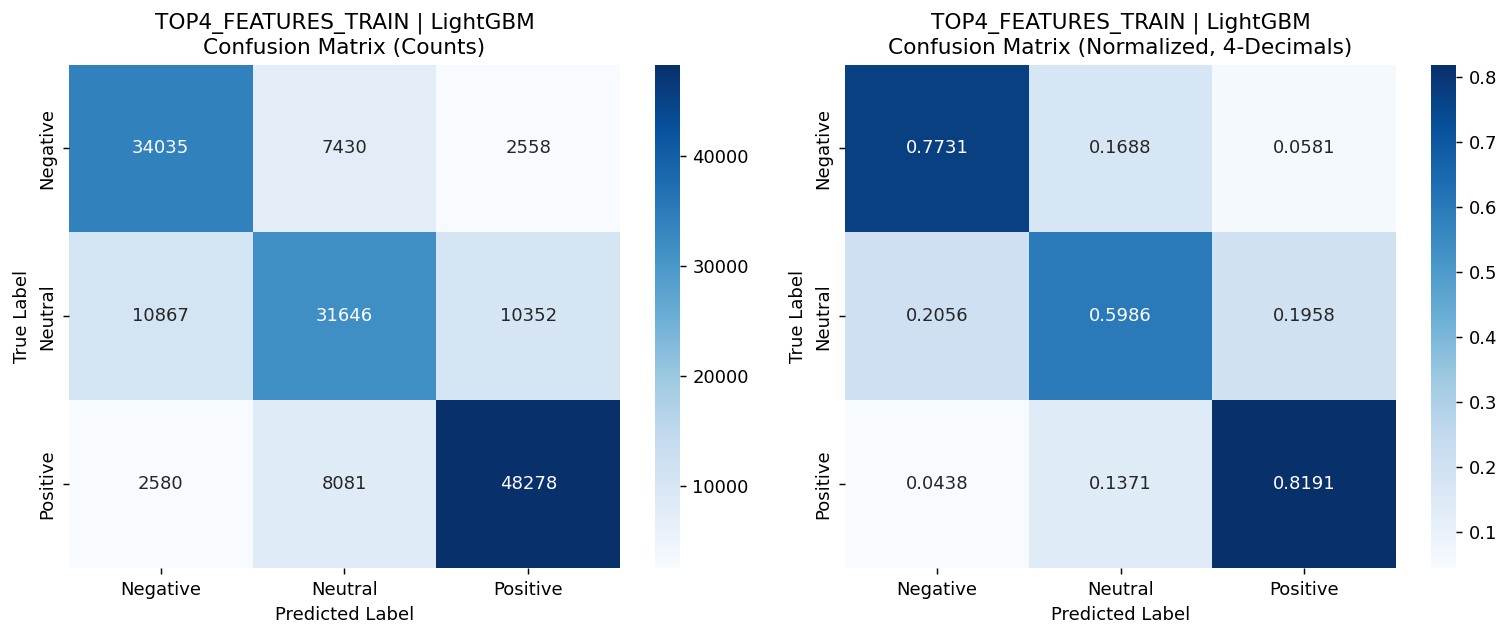


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.7168  Recall=0.7731  F1=0.7439  Support=44023
Neutral   : Precision=0.6711  Recall=0.5986  F1=0.6328  Support=52865
Positive  : Precision=0.7890  Recall=0.8191  F1=0.8038  Support=58939

TEST SET PERFORMANCE

[TOP4_FEATURES_TEST | LightGBM]
Accuracy=0.6353  F1_weighted=0.6323  Precision_weighted=0.6307  Recall_weighted=0.6353

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6274    0.6758    0.6507     11006
     Neutral     0.5213    0.4713    0.4951     13216
    Positive     0.7313    0.7521    0.7416     14735

    accuracy                         0.6353     38957
   macro avg     0.6267    0.6331    0.6291     38957
weighted avg     0.6307    0.6353    0.6323     38957



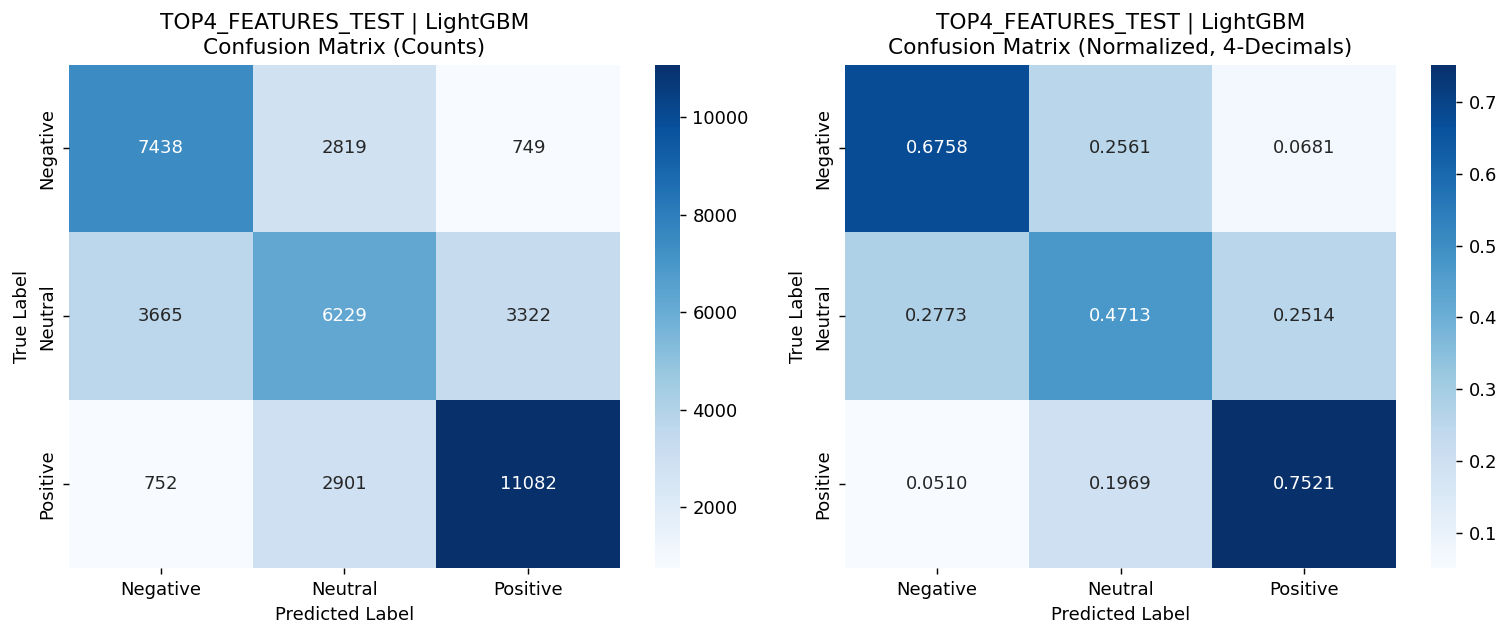


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6274  Recall=0.6758  F1=0.6507  Support=11006
Neutral   : Precision=0.5213  Recall=0.4713  F1=0.4951  Support=13216
Positive  : Precision=0.7313  Recall=0.7521  F1=0.7416  Support=14735

✅ Model saved to: /kaggle/working/LightGBM_Multiclass/TOP4_FEATURES/LightGBM_TOP4_Multiclass.pkl


In [5]:
# ======================================================================
# LIGHTGBM — TOP 4 FEATURES (Review Text, Title, Genre, TomatoMeter)
# ======================================================================

setup = "TOP4_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LIGHTGBM — TOP 4 FEATURES (Review Text, Title, Genre, TomatoMeter)")
print(f"{'='*70}")

# ---- DEFINING PARAMS LOCALLY (So this cell is independent of Part 5) ----
lgb_params_top4 = {
    'objective': 'multiclass',
    'num_class': N_CLASSES,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    
    # Model Complexity
    'max_depth': 8,
    'num_leaves': 128,  
    'learning_rate': 0.1,
    
    # Regularization & Sampling
    'bagging_fraction': 0.8, # subsample
    'bagging_freq': 1,
    'feature_fraction': 0.8, # colsample_bytree
    'min_child_weight': 5,
    'lambda_l1': 0.1, # reg_alpha
    'lambda_l2': 1.0, # reg_lambda
    
    # SWITCH TO CPU FOR STABILITY WITH SPARSE DATA
    'device': 'cpu', 
    'n_jobs': -1,  # Use all available Kaggle CPU cores
    
    'seed': RNG,
    'verbose': -1
}

# ---- STACK TOP 4 FEATURES ----
# Only tomatoMeter (col 0) from numeric features
# We assume Xtr_review, Xtr_title, etc. exist from Part 4
X_train_TOP4 = sparse.hstack([Xtr_review, Xtr_title, Xtr_genre, Xtr_num[:, 0:1]], format='csr') 
X_test_TOP4 = sparse.hstack([Xte_review, Xte_title, Xte_genre, Xte_num[:, 0:1]], format='csr')

print(f"X_train_TOP4 shape: {X_train_TOP4.shape}")
print(f"X_test_TOP4 shape: {X_test_TOP4.shape}")

# Create LightGBM Dataset
print("Creating LightGBM Datasets...")
sample_weights_train = np.array([class_weight_dict[label] for label in y_train])
train_data_top4 = lgb.Dataset(X_train_TOP4, label=y_train, weight=sample_weights_train)
test_data_top4 = lgb.Dataset(X_test_TOP4, label=y_test, reference=train_data_top4)

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores_top4 = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_TOP4, y_train), 1):
    X_tr_fold = X_train_TOP4[tr_idx]
    X_val_fold = X_train_TOP4[val_idx]
    y_tr_fold = y_train[tr_idx]
    y_val_fold = y_train[val_idx]
    
    w_tr_fold = np.array([class_weight_dict[label] for label in y_tr_fold])
    
    dtrain_fold = lgb.Dataset(X_tr_fold, label=y_tr_fold, weight=w_tr_fold)
    dval_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=dtrain_fold)
    
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0)
    ]
    
    model_fold = lgb.train(
        lgb_params_top4, # Using the local independent params
        dtrain_fold,
        num_boost_round=1000,
        valid_sets=[dtrain_fold, dval_fold],
        callbacks=callbacks
    )
    
    y_pred_prob_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(y_pred_prob_fold, axis=1)
    
    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = precision_recall_fscore_support(y_val_fold, y_pred_fold, average='weighted', zero_division=0)[2]
    cv_scores_top4.append((acc, f1))
    print(f"  Fold {fold}: acc={acc:.4f} | f1_weighted={f1:.4f}")

cv_arr_top4 = np.array(cv_scores_top4)
print(f"  LightGBM (TOP4 Features) CV mean±std | acc={cv_arr_top4[:,0].mean():.4f}±{cv_arr_top4[:,0].std():.4f} f1_w={cv_arr_top4[:,1].mean():.4f}±{cv_arr_top4[:,1].std():.4f}")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

lgb_top4 = lgb.train(
    lgb_params_top4, 
    train_data_top4, 
    num_boost_round=1000, 
    valid_sets=[train_data_top4, test_data_top4], 
    valid_names=['train', 'test'], 
    callbacks=callbacks
)

# ---- PREDICTIONS ----
print("\nMaking predictions...")
train_prob_top4 = lgb_top4.predict(X_train_TOP4)
train_pred_top4 = np.argmax(train_prob_top4, axis=1)

test_prob_top4 = lgb_top4.predict(X_test_TOP4)
test_pred_top4 = np.argmax(test_prob_top4, axis=1)

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics_top4 = evaluate_and_plot(
    "LightGBM", f"{setup}_TRAIN", y_train, train_prob_top4, train_pred_top4, save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics_top4 = evaluate_and_plot(
    "LightGBM", f"{setup}_TEST", y_test, test_prob_top4, test_pred_top4, save_dir
)

# ---- SAVE MODEL ----
model_path_top4 = os.path.join(save_dir, "LightGBM_TOP4_Multiclass.pkl")
with open(model_path_top4, "wb") as f:
    pickle.dump({
        "model": lgb_top4,
        "tfidf_review": tfidf_review,
        "tfidf_title": tfidf_title,
        "mlb": mlb_all,
        "scaler": scaler_all,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict,
        "lgb_params": lgb_params_top4,
        "feature_set": "Review Text, Title, Genre, TomatoMeter"
    }, f)

print(f"\n✅ Model saved to: {model_path_top4}")


LIGHTGBM — TOP 4 FEATURES (Review Text, Title, Genre, TomatoMeter)
X_train_TOP4 shape: (155827, 83922)
X_test_TOP4 shape: (38957, 83922)
Creating LightGBM Datasets...

Running 5-Fold Cross-Validation...
  Fold 1: acc=0.6277 | f1_weighted=0.6236
  Fold 2: acc=0.6292 | f1_weighted=0.6253
  Fold 3: acc=0.6316 | f1_weighted=0.6281
  Fold 4: acc=0.6270 | f1_weighted=0.6234
  Fold 5: acc=0.6309 | f1_weighted=0.6276
  LightGBM (TOP4 Features) CV mean±std | acc=0.6293±0.0018 f1_w=0.6256±0.0020

Training on full training set...
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.836938	test's multi_logloss: 0.848306
[200]	train's multi_logloss: 0.808748	test's multi_logloss: 0.82917
[300]	train's multi_logloss: 0.78914	test's multi_logloss: 0.817154
[400]	train's multi_logloss: 0.773651	test's multi_logloss: 0.808268
[500]	train's multi_logloss: 0.76055	test's multi_logloss: 0.801344
[600]	train's multi_logloss: 0.749361	test's multi_logloss: 0.796154
[7

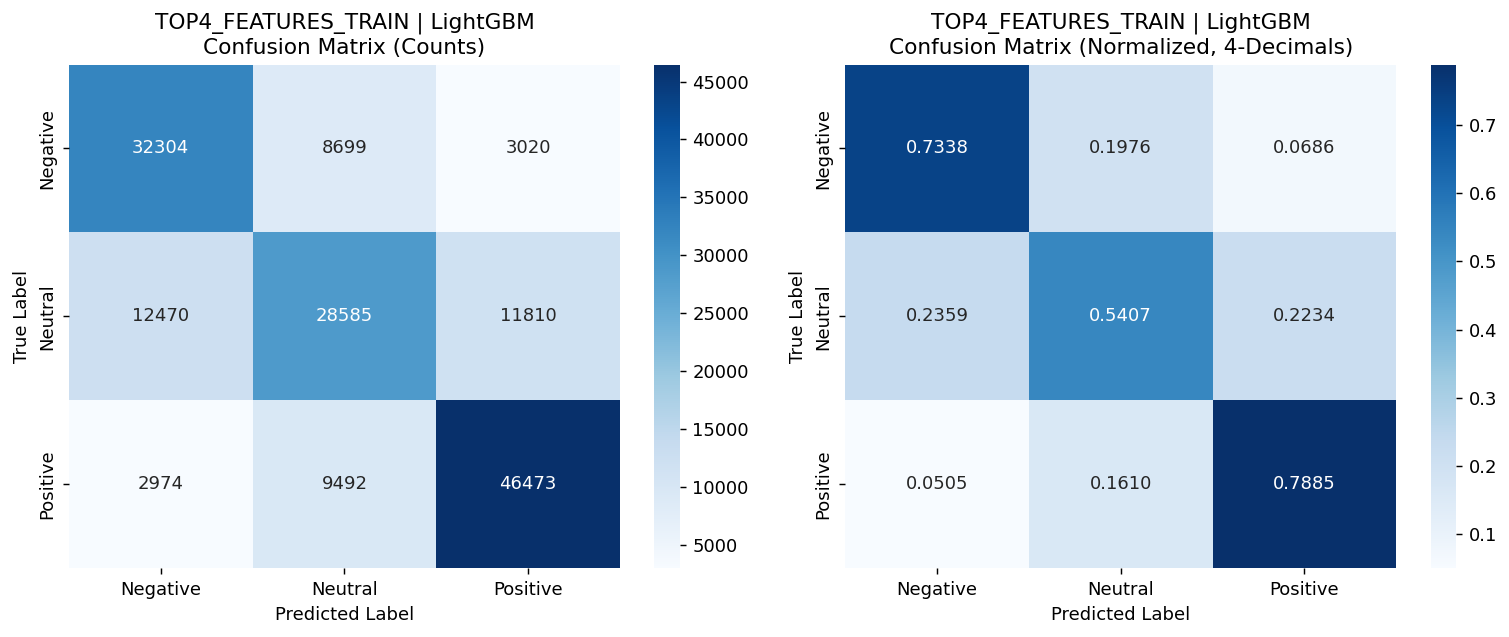


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6766  Recall=0.7338  F1=0.7040  Support=44023
Neutral   : Precision=0.6111  Recall=0.5407  F1=0.5738  Support=52865
Positive  : Precision=0.7581  Recall=0.7885  F1=0.7730  Support=58939

TEST SET PERFORMANCE

[TOP4_FEATURES_TEST | LightGBM]
Accuracy=0.6330  F1_weighted=0.6295  Precision_weighted=0.6279  Recall_weighted=0.6330

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6244    0.6788    0.6505     11006
     Neutral     0.5212    0.4638    0.4908     13216
    Positive     0.7261    0.7505    0.7381     14735

    accuracy                         0.6330     38957
   macro avg     0.6239    0.6311    0.6265     38957
weighted avg     0.6279    0.6330    0.6295     38957



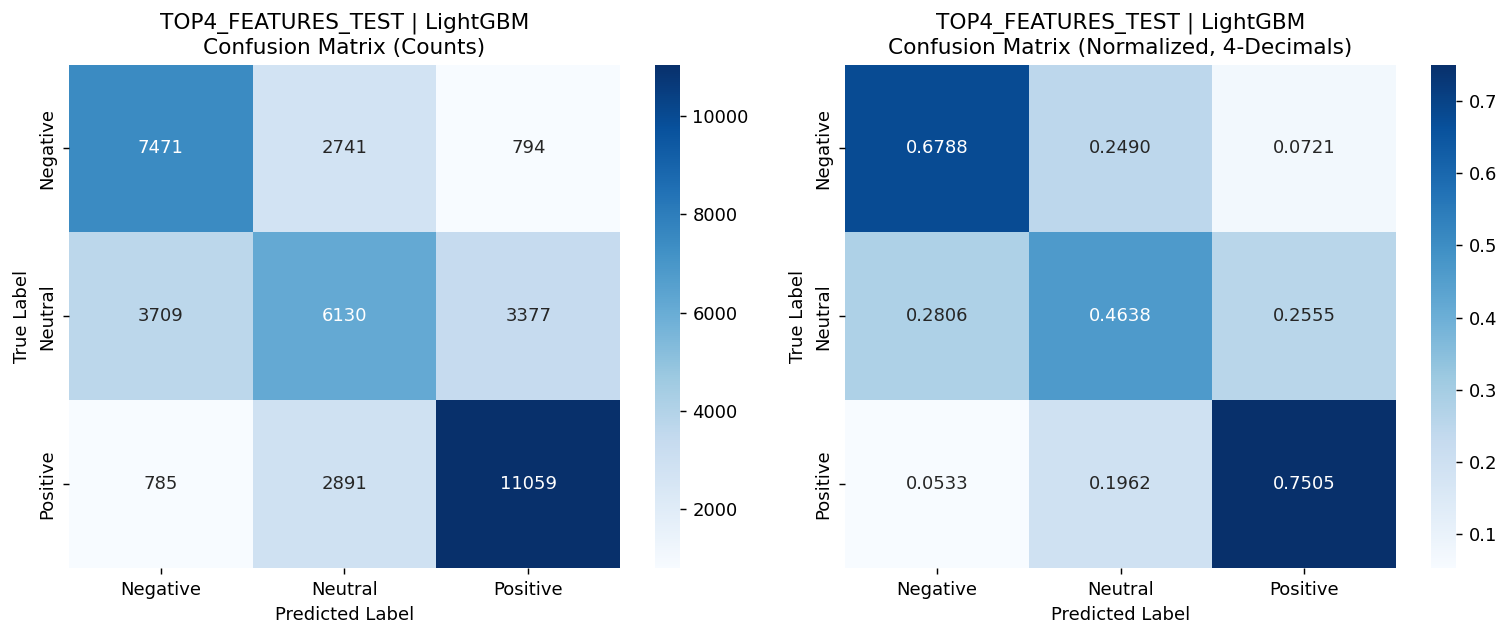


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6244  Recall=0.6788  F1=0.6505  Support=11006
Neutral   : Precision=0.5212  Recall=0.4638  F1=0.4908  Support=13216
Positive  : Precision=0.7261  Recall=0.7505  F1=0.7381  Support=14735

✅ Model saved to: /kaggle/working/LightGBM_Multiclass/TOP4_FEATURES/LightGBM_TOP4_Multiclass.pkl


In [6]:
# ======================================================================
# LIGHTGBM — TOP 4 FEATURES (Review Text, Title, Genre, TomatoMeter)
# ======================================================================

setup = "TOP4_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LIGHTGBM — TOP 4 FEATURES (Review Text, Title, Genre, TomatoMeter)")
print(f"{'='*70}")

# ---- DEFINING PARAMS LOCALLY (So this cell is independent of Part 5) ----
lgb_params_top4 = {
    'objective': 'multiclass',
    'num_class': N_CLASSES,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    
    # Model Complexity
    'max_depth': 5,
    'num_leaves': 28,  
    'learning_rate': 0.1,
    
    # Regularization & Sampling
    'bagging_fraction': 0.8, # subsample
    'bagging_freq': 1,
    'feature_fraction': 0.8, # colsample_bytree
    'min_child_weight': 5,
    'lambda_l1': 0.1, # reg_alpha
    'lambda_l2': 1.0, # reg_lambda
    
    # SWITCH TO CPU FOR STABILITY WITH SPARSE DATA
    'device': 'cpu', 
    'n_jobs': -1,  # Use all available Kaggle CPU cores
    
    'seed': RNG,
    'verbose': -1
}

# ---- STACK TOP 4 FEATURES ----
# Only tomatoMeter (col 0) from numeric features
# We assume Xtr_review, Xtr_title, etc. exist from Part 4
X_train_TOP4 = sparse.hstack([Xtr_review, Xtr_title, Xtr_genre, Xtr_num[:, 0:1]], format='csr') 
X_test_TOP4 = sparse.hstack([Xte_review, Xte_title, Xte_genre, Xte_num[:, 0:1]], format='csr')

print(f"X_train_TOP4 shape: {X_train_TOP4.shape}")
print(f"X_test_TOP4 shape: {X_test_TOP4.shape}")

# Create LightGBM Dataset
print("Creating LightGBM Datasets...")
sample_weights_train = np.array([class_weight_dict[label] for label in y_train])
train_data_top4 = lgb.Dataset(X_train_TOP4, label=y_train, weight=sample_weights_train)
test_data_top4 = lgb.Dataset(X_test_TOP4, label=y_test, reference=train_data_top4)

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores_top4 = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_TOP4, y_train), 1):
    X_tr_fold = X_train_TOP4[tr_idx]
    X_val_fold = X_train_TOP4[val_idx]
    y_tr_fold = y_train[tr_idx]
    y_val_fold = y_train[val_idx]
    
    w_tr_fold = np.array([class_weight_dict[label] for label in y_tr_fold])
    
    dtrain_fold = lgb.Dataset(X_tr_fold, label=y_tr_fold, weight=w_tr_fold)
    dval_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=dtrain_fold)
    
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0)
    ]
    
    model_fold = lgb.train(
        lgb_params_top4, # Using the local independent params
        dtrain_fold,
        num_boost_round=1000,
        valid_sets=[dtrain_fold, dval_fold],
        callbacks=callbacks
    )
    
    y_pred_prob_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(y_pred_prob_fold, axis=1)
    
    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = precision_recall_fscore_support(y_val_fold, y_pred_fold, average='weighted', zero_division=0)[2]
    cv_scores_top4.append((acc, f1))
    print(f"  Fold {fold}: acc={acc:.4f} | f1_weighted={f1:.4f}")

cv_arr_top4 = np.array(cv_scores_top4)
print(f"  LightGBM (TOP4 Features) CV mean±std | acc={cv_arr_top4[:,0].mean():.4f}±{cv_arr_top4[:,0].std():.4f} f1_w={cv_arr_top4[:,1].mean():.4f}±{cv_arr_top4[:,1].std():.4f}")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

lgb_top4 = lgb.train(
    lgb_params_top4, 
    train_data_top4, 
    num_boost_round=1000, 
    valid_sets=[train_data_top4, test_data_top4], 
    valid_names=['train', 'test'], 
    callbacks=callbacks
)

# ---- PREDICTIONS ----
print("\nMaking predictions...")
train_prob_top4 = lgb_top4.predict(X_train_TOP4)
train_pred_top4 = np.argmax(train_prob_top4, axis=1)

test_prob_top4 = lgb_top4.predict(X_test_TOP4)
test_pred_top4 = np.argmax(test_prob_top4, axis=1)

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics_top4 = evaluate_and_plot(
    "LightGBM", f"{setup}_TRAIN", y_train, train_prob_top4, train_pred_top4, save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics_top4 = evaluate_and_plot(
    "LightGBM", f"{setup}_TEST", y_test, test_prob_top4, test_pred_top4, save_dir
)

# ---- SAVE MODEL ----
model_path_top4 = os.path.join(save_dir, "LightGBM_TOP4_Multiclass.pkl")
with open(model_path_top4, "wb") as f:
    pickle.dump({
        "model": lgb_top4,
        "tfidf_review": tfidf_review,
        "tfidf_title": tfidf_title,
        "mlb": mlb_all,
        "scaler": scaler_all,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict,
        "lgb_params": lgb_params_top4,
        "feature_set": "Review Text, Title, Genre, TomatoMeter"
    }, f)

print(f"\n✅ Model saved to: {model_path_top4}")


LIGHTGBM — TOP 4 FEATURES (Review Text, Title, Genre, TomatoMeter)
X_train_TOP4 shape: (155827, 83922)
X_test_TOP4 shape: (38957, 83922)
Creating LightGBM Datasets...

Running 5-Fold Cross-Validation...
  Fold 1: acc=0.6259 | f1_weighted=0.6218
  Fold 2: acc=0.6268 | f1_weighted=0.6228
  Fold 3: acc=0.6273 | f1_weighted=0.6236
  Fold 4: acc=0.6224 | f1_weighted=0.6187
  Fold 5: acc=0.6291 | f1_weighted=0.6257
  LightGBM (TOP4 Features) CV mean±std | acc=0.6263±0.0022 f1_w=0.6225±0.0023

Training on full training set...
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.849632	test's multi_logloss: 0.855042
[200]	train's multi_logloss: 0.825578	test's multi_logloss: 0.836608
[300]	train's multi_logloss: 0.808941	test's multi_logloss: 0.824993
[400]	train's multi_logloss: 0.796034	test's multi_logloss: 0.816487
[500]	train's multi_logloss: 0.785024	test's multi_logloss: 0.809577
[600]	train's multi_logloss: 0.775737	test's multi_logloss: 0.804228

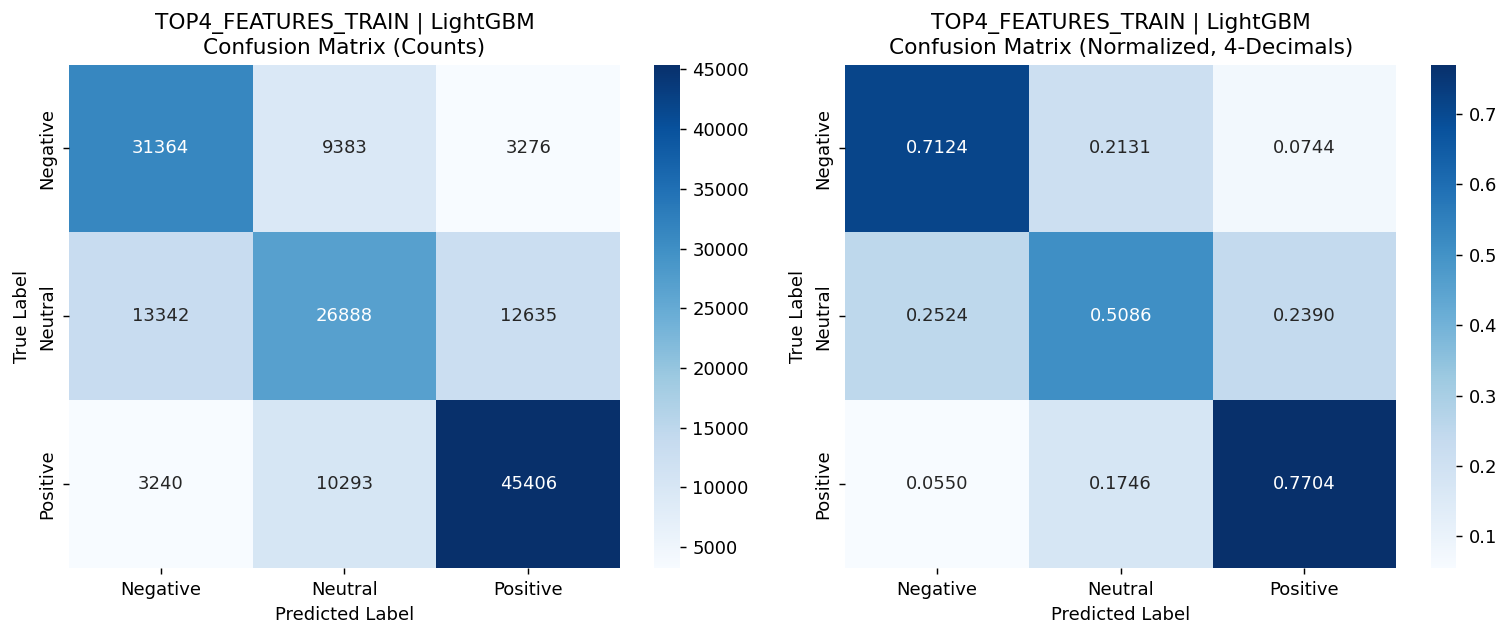


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6542  Recall=0.7124  F1=0.6821  Support=44023
Neutral   : Precision=0.5774  Recall=0.5086  F1=0.5408  Support=52865
Positive  : Precision=0.7405  Recall=0.7704  F1=0.7552  Support=58939

TEST SET PERFORMANCE

[TOP4_FEATURES_TEST | LightGBM]
Accuracy=0.6283  F1_weighted=0.6246  Precision_weighted=0.6229  Recall_weighted=0.6283

--- Classification Report (4 Decimal Places) ---
              precision    recall  f1-score   support

    Negative     0.6193    0.6752    0.6460     11006
     Neutral     0.5169    0.4576    0.4854     13216
    Positive     0.7208    0.7464    0.7333     14735

    accuracy                         0.6283     38957
   macro avg     0.6190    0.6264    0.6216     38957
weighted avg     0.6229    0.6283    0.6246     38957



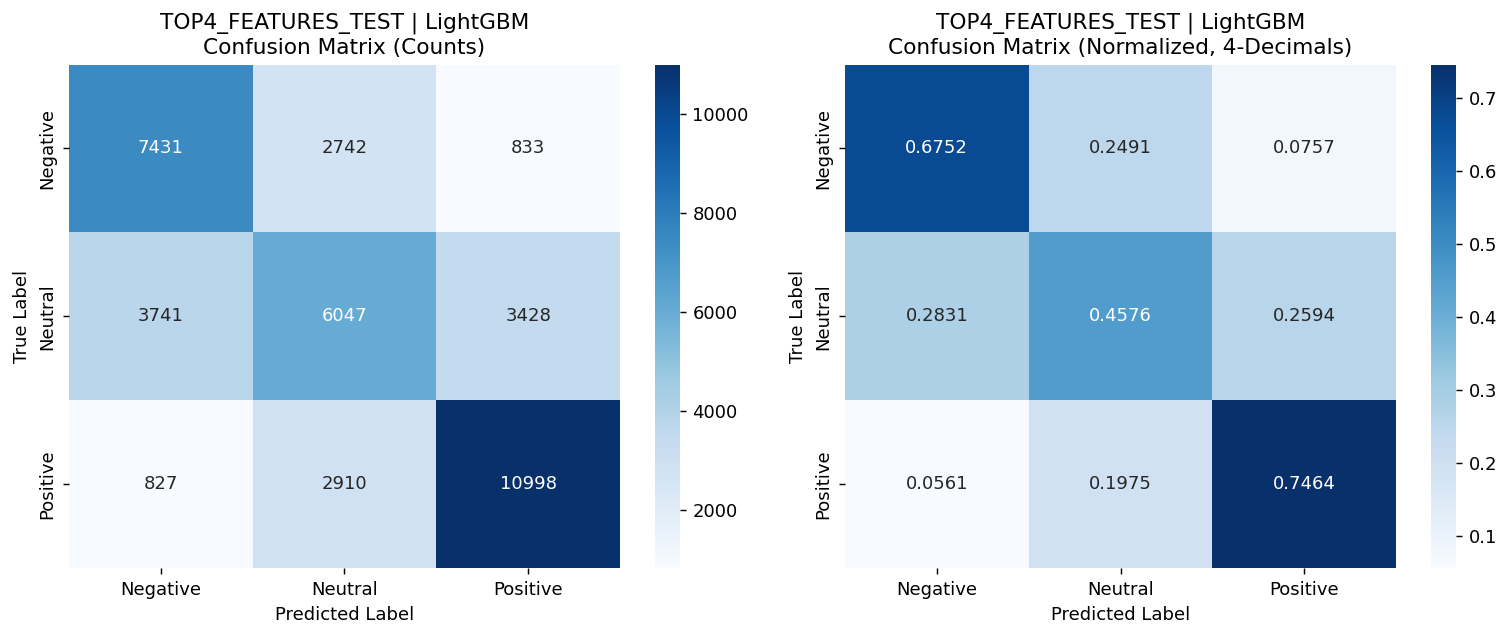


--- Per-Class Metrics (4 Decimals) ---
Negative  : Precision=0.6193  Recall=0.6752  F1=0.6460  Support=11006
Neutral   : Precision=0.5169  Recall=0.4576  F1=0.4854  Support=13216
Positive  : Precision=0.7208  Recall=0.7464  F1=0.7333  Support=14735

✅ Model saved to: /kaggle/working/LightGBM_Multiclass/TOP4_FEATURES/LightGBM_TOP4_Multiclass.pkl


In [7]:
# ======================================================================
# LIGHTGBM — TOP 4 FEATURES (Review Text, Title, Genre, TomatoMeter)
# ======================================================================

setup = "TOP4_FEATURES"
save_dir = os.path.join(BASE_SAVE_DIR, setup)
os.makedirs(save_dir, exist_ok=True)

print(f"\n{'='*70}")
print(f"LIGHTGBM — TOP 4 FEATURES (Review Text, Title, Genre, TomatoMeter)")
print(f"{'='*70}")

# ---- DEFINING PARAMS LOCALLY (So this cell is independent of Part 5) ----
lgb_params_top4 = {
    'objective': 'multiclass',
    'num_class': N_CLASSES,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    
    # Model Complexity
    'max_depth': 4,
    'num_leaves': 15,  
    'learning_rate': 0.1,
    
    # Regularization & Sampling
    'bagging_fraction': 0.8, # subsample
    'bagging_freq': 1,
    'feature_fraction': 0.8, # colsample_bytree
    'min_child_weight': 10,
    'lambda_l1': 0.5, # reg_alpha
    'lambda_l2': 2.0, # reg_lambda
    
    # SWITCH TO CPU FOR STABILITY WITH SPARSE DATA
    'device': 'cpu', 
    'n_jobs': -1,  # Use all available Kaggle CPU cores
    
    'seed': RNG,
    'verbose': -1
}

# ---- STACK TOP 4 FEATURES ----
# Only tomatoMeter (col 0) from numeric features
# We assume Xtr_review, Xtr_title, etc. exist from Part 4
X_train_TOP4 = sparse.hstack([Xtr_review, Xtr_title, Xtr_genre, Xtr_num[:, 0:1]], format='csr') 
X_test_TOP4 = sparse.hstack([Xte_review, Xte_title, Xte_genre, Xte_num[:, 0:1]], format='csr')

print(f"X_train_TOP4 shape: {X_train_TOP4.shape}")
print(f"X_test_TOP4 shape: {X_test_TOP4.shape}")

# Create LightGBM Dataset
print("Creating LightGBM Datasets...")
sample_weights_train = np.array([class_weight_dict[label] for label in y_train])
train_data_top4 = lgb.Dataset(X_train_TOP4, label=y_train, weight=sample_weights_train)
test_data_top4 = lgb.Dataset(X_test_TOP4, label=y_test, reference=train_data_top4)

# ---- K-FOLD CROSS-VALIDATION ----
print("\nRunning 5-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_scores_top4 = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_TOP4, y_train), 1):
    X_tr_fold = X_train_TOP4[tr_idx]
    X_val_fold = X_train_TOP4[val_idx]
    y_tr_fold = y_train[tr_idx]
    y_val_fold = y_train[val_idx]
    
    w_tr_fold = np.array([class_weight_dict[label] for label in y_tr_fold])
    
    dtrain_fold = lgb.Dataset(X_tr_fold, label=y_tr_fold, weight=w_tr_fold)
    dval_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=dtrain_fold)
    
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0)
    ]
    
    model_fold = lgb.train(
        lgb_params_top4, # Using the local independent params
        dtrain_fold,
        num_boost_round=1000,
        valid_sets=[dtrain_fold, dval_fold],
        callbacks=callbacks
    )
    
    y_pred_prob_fold = model_fold.predict(X_val_fold)
    y_pred_fold = np.argmax(y_pred_prob_fold, axis=1)
    
    acc = accuracy_score(y_val_fold, y_pred_fold)
    f1 = precision_recall_fscore_support(y_val_fold, y_pred_fold, average='weighted', zero_division=0)[2]
    cv_scores_top4.append((acc, f1))
    print(f"  Fold {fold}: acc={acc:.4f} | f1_weighted={f1:.4f}")

cv_arr_top4 = np.array(cv_scores_top4)
print(f"  LightGBM (TOP4 Features) CV mean±std | acc={cv_arr_top4[:,0].mean():.4f}±{cv_arr_top4[:,0].std():.4f} f1_w={cv_arr_top4[:,1].mean():.4f}±{cv_arr_top4[:,1].std():.4f}")

# ---- FIT ON FULL TRAIN ----
print("\nTraining on full training set...")
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

lgb_top4 = lgb.train(
    lgb_params_top4, 
    train_data_top4, 
    num_boost_round=1000, 
    valid_sets=[train_data_top4, test_data_top4], 
    valid_names=['train', 'test'], 
    callbacks=callbacks
)

# ---- PREDICTIONS ----
print("\nMaking predictions...")
train_prob_top4 = lgb_top4.predict(X_train_TOP4)
train_pred_top4 = np.argmax(train_prob_top4, axis=1)

test_prob_top4 = lgb_top4.predict(X_test_TOP4)
test_pred_top4 = np.argmax(test_prob_top4, axis=1)

# ---- EVALUATION ----
print(f"\n{'='*70}")
print("TRAIN SET PERFORMANCE")
print(f"{'='*70}")
train_metrics_top4 = evaluate_and_plot(
    "LightGBM", f"{setup}_TRAIN", y_train, train_prob_top4, train_pred_top4, save_dir
)

print(f"\n{'='*70}")
print("TEST SET PERFORMANCE")
print(f"{'='*70}")
test_metrics_top4 = evaluate_and_plot(
    "LightGBM", f"{setup}_TEST", y_test, test_prob_top4, test_pred_top4, save_dir
)

# ---- SAVE MODEL ----
model_path_top4 = os.path.join(save_dir, "LightGBM_TOP4_Multiclass.pkl")
with open(model_path_top4, "wb") as f:
    pickle.dump({
        "model": lgb_top4,
        "tfidf_review": tfidf_review,
        "tfidf_title": tfidf_title,
        "mlb": mlb_all,
        "scaler": scaler_all,
        "class_names": class_names,
        "class_weight_dict": class_weight_dict,
        "lgb_params": lgb_params_top4,
        "feature_set": "Review Text, Title, Genre, TomatoMeter"
    }, f)

print(f"\n✅ Model saved to: {model_path_top4}")